# Step 1: download osm data (json) and simplify (object) by osmnx
- input:  spatial range, roadnet level/type
- output: beijing_osmnx_networkx.obj and beijing_osmnx_original.json

In [1]:
import pickle
import copy
import json
import numpy as np
import random
import osmnx as ox
import networkx as nx
from osmnx.core import osm_net_download

In [2]:
north,south,west,east = 39.9655432200,39.8454492313,116.3115692139 ,116.4626312256
network_type = 'drive_service'
infrastructure = 'way["highway"~"tertiary|secondary|primary"]'

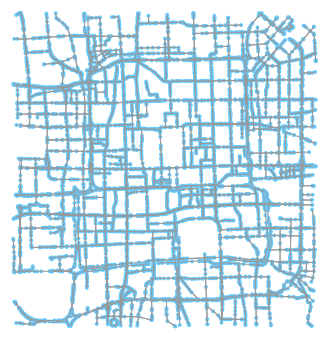

In [3]:
G0 = ox.graph_from_bbox(north,south,east,west,network_type=network_type,simplify=False,infrastructure=infrastructure)
fig, ax = ox.plot_graph(G0)

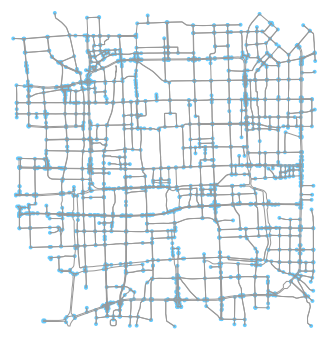

(<Figure size 542.229x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x21d61a71550>)

In [4]:
G = ox.simplify_graph(G0,strict=True)
Whole = [(len(c),c) for c in nx.strongly_connected_components(G)]
re = [i for i in G.nodes() if i not in max(Whole)[1]]
G.remove_nodes_from(re)
ox.plot_graph(G)

In [15]:
print("nodes:{} edges:{}".format(len(G.nodes.items()), len(G.edges.items())))

nodes:2211 edges:4402


In [5]:
pickle.dump(G, open("data/beijing_osmnx_networkx.obj","wb"), protocol=2)

In [9]:
response_jsons = osm_net_download(north=north, south=south, east=east,west=west, network_type=network_type,infrastructure=infrastructure)
json.dump(response_jsons, open("data/beijing_osmnx_original.json", "w"), indent=2)

# Step 2: process networkx object and osm.json data with sumopy in SUMO

this step is employed in the ubuntu server with sumo (version>0.28,python2,networkx) installed

- TypeError: list indices must be integers, not str
    - `for element in osmdata['elements']:` -> `for element in osmdata[0]['elements']:`
    - line 2376 in sumopy.coremodules.scenario.networktools.import_osmdata
- UnicodeEncodeError: 'ascii' codec can't encode characters in position 13-17: ordinal not in range(128)
    - python 2.7 编码问题 `print_attrs(osmattrs)`
    - line 178 in sumopy.coremodules.scenario.networktools.make_sumoattrs
- pickle(object) compatibility problem
    - between python2 and python3 -> [solution](https://blog.csdn.net/u013185349/article/details/84778751) declare protocol=2 in pickle.dump()
    - between windows and linux -> save object in linux platform
    - ImportError: No module named reportviews -> networkx version (upgrade 1.11->2.x)
- bikemode and MODES
    - bikemode 只读 -> line 2322 in networktools.__init__, from `perm='r'` to  `perm='rw'`
    - network.networktools: MODES not defined -> add `from coremodules.network.network import MODES` in the start of it
    - remove `bicycle` in line 2322 in networktools.__init__

with osm.json and osm.obj as input, import them in the scenario and then directly export them as the sumo.net.xml by network.export
- input: beijing_osmnx_original.json and beijing_osmnx_networkx.obj
- output: beijing_sumopy.net.xml

another left question is about the lane number, we use the default lane number as 1 in the current work

# Step 3: convert sumo.net.xml into cityflow.json and fix traffic light issues

we first direclty convert the sumo.net.xml from sumopy by the cityflow/tools/converter.py and then fix them with the following codes
- input:  beijing_sumopy.net.xml
- output: beijing_cityflow.json

In [95]:
road = json.loads(open("data/beijing_cityflow_L2.json").read())
intersection_count,no_phase = [0,0,0], []
for inter in road["intersections"]:
    intersection_count[0] += 1
    if inter.__contains__('trafficLight'): # for python 3, has_key for python 2
        intersection_count[1] += 1
        if len(inter["trafficLight"]["lightphases"])==0:
            no_phase.append([inter["id"],inter["virtual"]])
        else:
            intersection_count[2] += 1
print("current status:{}".format(intersection_count))

for i, inter in enumerate(road["intersections"]):
    if len(inter["trafficLight"]["lightphases"])==0:
        if road["intersections"][i]["id"]==inter["id"]:
            if not inter["virtual"]:
                print(inter["id"], road["intersections"][i]["virtual"])
                road["intersections"][i]["virtual"] = True
                print(inter["id"], road["intersections"][i]["virtual"])
json.dump(road, open("data/beijing_cityflow_L2_fixed.json", "w"))

current status:[2211, 2211, 2138]
1410714249 False
1410714249 True
1598502584 False
1598502584 True
2048161746 False
2048161746 True
2108372983 False
2108372983 True
2230046188 False
2230046188 True
2480733161 False
2480733161 True


# Step 4: genererate vehicle flow and match them with the current roadnet

In [2]:
G = pickle.load(open("./data/beijing_osmnx_networkx.obj","rb"))
trip = np.load('./data/real_od_9am.npy')
nodes_mapping = json.load(open("./data/net_dictionary.rs"))
nodes_mapping_inverse = dict([(v,int(k)) for (k,v) in nodes_mapping.items()])
cityflow_road = json.load(open("data/beijing_cityflow_L2_fixed.json"))

In [3]:
np.sum(np.sum(trip, axis=1),axis=1)

array([19883, 20434, 20870, 21599, 22121, 22629], dtype=uint32)

In [4]:
node = {}
for index,data in enumerate(G.nodes(data=True)):
    node[data[0]] = index+1
nodes = {k:v for v,k in node.items()}

cnt = 0
for line in open('./data/9.00am-9.10am.txt','r'):
    a = line
    u = int(a[a.find(':')+1:a.find('-')])
    v = int(a[a.find('>')+1:a.find(' ')])
    flo = float(a[a.find('time:')+5:a.find('\n')])
    cnt = cnt+1
    
    for j in range(len(G.get_edge_data(nodes[u+1],nodes[v+1]))):
        try:
            if G.get_edge_data(nodes[u+1],nodes[v+1])[j]['weight']:
                continue
        except KeyError:
            break
            
    G.get_edge_data(nodes[u+1],nodes[v+1])[j]['weight'] = flo

In [5]:
# 统计路口id的道路连接情况
roads_for_nodes = {}
for node in cityflow_road["intersections"]:
    roads_for_nodes[node["id"]] = {"enter":[],"leave":[]}
    for link in node["roadLinks"]:
        if link["startRoad"] not in roads_for_nodes[node["id"]]["enter"]:
            roads_for_nodes[node["id"]]["enter"].append(link["startRoad"])
        if link["endRoad"] not in roads_for_nodes[node["id"]]["leave"]:
            roads_for_nodes[node["id"]]["leave"].append(link["endRoad"])

# 统计路口id的道路lane
road_lanes = {}
for road in cityflow_road["roads"]:
    road_lanes[road["id"]] = len(road["lanes"])
    
# 给定有序的路口id，给出其连接路段id
path_for_nodes = {}
for node_src in roads_for_nodes:
    for node_dst in roads_for_nodes:
        if node_src==node_dst:
            continue
        path_index = str(node_src) + "->" + str(node_dst)
        leave_road = set(roads_for_nodes[str(node_src)]["leave"])
        enter_road = set(roads_for_nodes[str(node_dst)]["enter"])
        if len(leave_road.intersection(enter_road))==0:
            continue
        else:
            path_for_nodes[path_index] = list(leave_road.intersection(enter_road))[0]

# virtual nodes
virtual_nodes = {"nolink":[],"virtual":[], "merge":[]}
for node in cityflow_road["intersections"]:
    if len(node["roadLinks"])==0:
        virtual_nodes["nolink"].append(node["id"])
    if str(node["virtual"])=="True":
        virtual_nodes["virtual"].append(node["id"])
virtual_nodes["merge"] = list(set(virtual_nodes["nolink"])|set(virtual_nodes["virtual"]))

In [6]:
print("road_for_nodes:{} path_for_nodes:{} virual_nodes:nolink-{}/virtual-{}".format(len(roads_for_nodes), 
                                                                                     len(path_for_nodes),
                                                                                     len(virtual_nodes["nolink"]), 
                                                                                     len(virtual_nodes["virtual"])))
virtual_nodes["merge"] = list(set(virtual_nodes["nolink"])|set(virtual_nodes["virtual"]))

road_for_nodes:2211 path_for_nodes:4238 virual_nodes:nolink-72/virtual-78


In [7]:
vehicle_head = {
   "length": 5.0,
   "width": 2.0,
   "maxPosAcc": 2.0,
   "maxNegAcc": 4.5,
   "usualPosAcc": 2.0,
   "usualNegAcc": 4.5,
   "minGap": 2.5,
   "maxSpeed": 11.111,
   "headwayTime": 2
  }

In [10]:
random.seed(1)
vehicle_flow = []
change, error = 0, 0
for src_node in list(G.nodes()):
    # 处理虚拟节点
    if str(src_node) in virtual_nodes["merge"]:
        continue
    for dst_node in list(G.nodes()):
        if str(dst_node) in virtual_nodes["merge"]:
            continue
        
        # 处理flow为0的点
        flow_value = trip[0, nodes_mapping_inverse[str(src_node)], nodes_mapping_inverse[str(dst_node)]]
        if flow_value == 0:
            continue
        
        node_list = nx.shortest_path(G, source=src_node, target=dst_node)
        edge_nodes = list(zip(node_list[:-1], node_list[1:]))
        
        path_list = []
        flag = 0 # 进一步处理node
        for eu, ev in edge_nodes:
            if str(eu)+"->"+str(ev) not in path_for_nodes or str(eu) in virtual_nodes["merge"] or str(ev) in virtual_nodes["merge"]:
                flag = 1
                break
            path_list.append(path_for_nodes[str(eu)+"->"+str(ev)])
        if flag:
            error += 1
            print("error caused by virtual intersection:", src_node, dst_node, node_list,str(eu)+"->"+str(ev))
            continue

        for i in range(max(int(flow_value/2),1)):
            random_time = random.randint(0,600) # random generate time in 600s
#             threshold = 2 if random.randint(1,10)<5 else 0 
#             if random.randint(1,10)<4:
#                 random_time = random.randint(0,1800)
#             else:
#                 random_time = random.randint(300,600)
            vehicle_flow_unit = {"vehicle":vehicle_head,
                                 "route":path_list,
                                 "interval": 1.0,
                                 "startTime": random_time,
                                 "endTime": random_time
                                }
            vehicle_flow.append(vehicle_flow_unit)
vehicle_flow_order = sorted(vehicle_flow, key=lambda x: x["startTime"])
json.dump(vehicle_flow_order, open("./data/beijing_vehicle_flow_L2_300.json","w"),indent=2)

error caused by virtual intersection: 528909202 1982049864 [528909202, 4580060672, 528911157, 2108372983, 1365113263, 2285990048, 2285990050, 265710690, 1982049864] 528911157->2108372983
error caused by virtual intersection: 528911157 1253535147 [528911157, 2108372983, 1365113263, 2285990048, 1365113238, 290598252, 656086849, 1253535147] 528911157->2108372983
error caused by virtual intersection: 1305972690 1449318308 [1305972690, 35552589, 76456821, 1942597351, 76456822, 1842188224, 1736610693, 35552324, 32899017, 1736610643, 1114097887, 1114088466, 1114088475, 1114088468, 1819087374, 1819087334, 1819087329, 1977226294, 100651857, 266110505, 100653372, 1300406443, 31018238, 336380069, 266112314, 1362315796, 1861654993, 1362315802, 1449318308] 100653372->1300406443
error caused by virtual intersection: 734170185 1598459387 [734170185, 734169511, 77746334, 2480776634, 1599489635, 77746332, 1549077228, 322121114, 1231628428, 322121120, 1410714249, 734418814, 1598453939, 1598459387] 32212

In [89]:
# for node in cityflow_road["intersections"]:
#     if node["id"] in ["100653372", "1300406443"]:
#         print(node)
#         print(roads_for_nodes[node["id"]])
# 100653372->1300406443: 人行道

In [248]:
# vehicle_flow_order = sorted(vehicle_flow, key=lambda x: x["startTime"])

In [14]:
print(len(vehicle_flow), error, change)

15765 128 0


In [24]:
json.dump(vehicle_flow_order, open("./data/beijing_vehicle_flow_L2_toy.json","w"),indent=2)

In [255]:
def update_time(x, delta=0, interval=0):
    x["endTime"] += delta
    x["interval"] = interval
    return x

In [257]:
# x = vehicle_flow_order[0]
# x2 = update_time(copy.deepcopy(x), delta=10, interval=2)
# print(x)
# print(x2)

{'vehicle': {'length': 5.0, 'width': 2.0, 'maxPosAcc': 2.0, 'maxNegAcc': 4.5, 'usualPosAcc': 2.0, 'usualNegAcc': 4.5, 'minGap': 2.5, 'maxSpeed': 11.111, 'headwayTime': 2}, 'route': ['220917660#0', '8861571#1', '164439295#0', '164439295#2', '164439295#1', '122923050#0', '164919868#0', '150608625#0', '122923048#0', '122923044#0'], 'interval': 1.0, 'startTime': 0, 'endTime': 0}
{'vehicle': {'length': 5.0, 'width': 2.0, 'maxPosAcc': 2.0, 'maxNegAcc': 4.5, 'usualPosAcc': 2.0, 'usualNegAcc': 4.5, 'minGap': 2.5, 'maxSpeed': 11.111, 'headwayTime': 2}, 'route': ['220917660#0', '8861571#1', '164439295#0', '164439295#2', '164439295#1', '122923050#0', '164919868#0', '150608625#0', '122923048#0', '122923044#0'], 'interval': 2, 'startTime': 0, 'endTime': 10}


In [261]:
json.dump([update_time(copy.deepcopy(x), delta=20, interval=10) for x in vehicle_flow_order if x["startTime"]<700], 
          open("./data/beijing_vehicle_flow_L2_X3.json","w"),indent=2) # 130-132

# Fix Bugs!!! Virtual Nodes!!!
python: /tmp/pip-req-build-svaxa1aa/src/vehicle/router.cpp:34: CityFlow::Drivable* CityFlow::Router::getFirstDrivable() const: Assertion `candidateLanes.size() > 0' failed.
Aborted (core dumped)

In [173]:
for v in vehicle_flow[1120:1150]:
    print(v["route"], v["startTime"])
    # '200877432#0', '200877433#0'之间有问题

['141524690#0', '141524690#1', '723613422#0', '161802136#0', '164952663#0', '146581679#0', '146581679#2'] 12
['141524720#0', '146689777#0', '146689773#0', '164954107#0'] 549
['141524720#0', '146689777#0', '146689773#0', '164954107#0'] 465
['141524746#1', '141524746#0', '194291838#0', '33612552#0', '194291836#0', '127843730#3', '127843730#0', '-38758392#0', '4493469#1', '146581680#2'] 526
['141524746#1', '146581678#0', '146581678#4', '162359313#1', '-162359310#0', '150926368#1', '150926368#0', '144919564#2', '127844316#0'] 124
['141524746#1', '146581678#0', '146581678#4', '162359313#1', '-162359310#0', '150926368#1', '150926368#0', '144919564#2', '127844316#0'] 492
['141524746#1', '146581678#0', '146581678#4', '162359313#1', '-162359310#0', '150926368#1', '150926368#0', '144919564#2', '127844316#0'] 45
['141524746#1', '141524746#0', '141524687#1', '141524687#3', '141524687#0', '162359304#0', '162359316#2', '161802255#3'] 538
['141524746#1', '141524746#0', '194291838#0', '33612552#0', '1

In [147]:
for road in cityflow_road["roads"]:
    if road["id"] in ["200877432#0","144919573#0","200877433#0"]:
        print(road)

{'id': '144919573#0', 'points': [{'x': 5460.31, 'y': 5897.0}, {'x': 5588.19, 'y': 5900.5}], 'lanes': [{'width': 4, 'maxSpeed': 11.111}, {'width': 4, 'maxSpeed': 11.111}], 'startIntersection': '1300401040', 'endIntersection': '1599489653'}
{'id': '200877432#0', 'points': [{'x': 1921.94, 'y': 11247.0}, {'x': 2233.41, 'y': 11057.0}], 'lanes': [{'width': 4, 'maxSpeed': 11.111}, {'width': 4, 'maxSpeed': 11.111}, {'width': 4, 'maxSpeed': 11.111}], 'startIntersection': '528911157', 'endIntersection': '2108372983'}
{'id': '200877433#0', 'points': [{'x': 2233.41, 'y': 11057.0}, {'x': 2703.81, 'y': 10851.0}], 'lanes': [{'width': 4, 'maxSpeed': 11.111}, {'width': 4, 'maxSpeed': 11.111}], 'startIntersection': '2108372983', 'endIntersection': '1365113263'}


In [166]:
path_for_nodes_inverse = dict([(v,k) for (k,v) in path_for_nodes.items()])
for path in path_for_nodes_inverse:
    if path == "200877432#0":
        print(path_for_nodes_inverse[path])

528911157->2108372983


In [167]:
for inter in cityflow_road["intersections"]:
    if inter["id"] in ["528911157","2108372983"]:
        print(inter)

{'id': '2108372983', 'point': {'x': 2233.41, 'y': 11057.0}, 'width': 0, 'roads': ['200877432#0', '200877433#0'], 'roadLinks': [{'type': 'go_straight', 'startRoad': '200877432#0', 'endRoad': '200877433#0', 'direction': 0, 'laneLinks': [{'startLaneIndex': 0, 'endLaneIndex': 0, 'points': [{'x': 2233.24, 'y': 11059.72}, {'x': 2235.15, 'y': 11057.96}]}, {'startLaneIndex': 0, 'endLaneIndex': 1, 'points': [{'x': 2233.24, 'y': 11059.72}, {'x': 2233.84, 'y': 11054.98}]}, {'startLaneIndex': 1, 'endLaneIndex': 0, 'points': [{'x': 2231.7, 'y': 11056.86}, {'x': 2235.15, 'y': 11057.96}]}, {'startLaneIndex': 1, 'endLaneIndex': 1, 'points': [{'x': 2231.7, 'y': 11056.86}, {'x': 2233.84, 'y': 11054.98}]}, {'startLaneIndex': 2, 'endLaneIndex': 0, 'points': [{'x': 2230.57, 'y': 11054.77}, {'x': 2235.15, 'y': 11057.96}]}, {'startLaneIndex': 2, 'endLaneIndex': 1, 'points': [{'x': 2230.57, 'y': 11054.77}, {'x': 2233.84, 'y': 11054.98}]}]}], 'trafficLight': {'roadLinkIndices': [0], 'lightphases': []}, 'virtua